## Tuning BERT and saving for classification

In [1]:
#installing required dependencies
!pip install -q -U tensorflow-text
!pip install -q tf-models-official

     |████████████████████████████████| 4.4 MB 5.6 MB/s 
     |████████████████████████████████| 1.8 MB 5.2 MB/s 
     |████████████████████████████████| 37.1 MB 55 kB/s 
     |████████████████████████████████| 596 kB 40.7 MB/s 
     |████████████████████████████████| 1.2 MB 37.7 MB/s 
     |████████████████████████████████| 99 kB 8.6 MB/s 
     |████████████████████████████████| 352 kB 47.9 MB/s 
     |████████████████████████████████| 1.1 MB 32.9 MB/s 
     |████████████████████████████████| 213 kB 31.6 MB/s 
     |████████████████████████████████| 43 kB 1.9 MB/s 
     |████████████████████████████████| 90 kB 8.5 MB/s 


In [2]:
#importing required libraries
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

In [3]:
#downloading the IMDB dataset
url = 'https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'

dataset = tf.keras.utils.get_file('aclImdb_v1.tar.gz', url,
                                  untar=True, cache_dir='.',
                                  cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

train_dir = os.path.join(dataset_dir, 'train')

# remove unused folders to make it easier to load the data
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

84140032/84125825 [==============================] - 2s 0us/step


In [4]:
#creating tensorflow dataset from the directory
#creating the validation dataset of 80:20 ratio
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/test',
    batch_size=batch_size)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


In [5]:
#checking few reviews
for text_batch, label_batch in train_ds.take(1):
  for i in range(3):
    print(f'Review: {text_batch.numpy()[i]}')
    label = label_batch.numpy()[i]
    print(f'Label : {label} ({class_names[label]})')

Review: b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label : 0 (neg)
Review: b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they

In [6]:
#loading the BERT model
bert_model = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1'
# preprocessing BERT model
bert_preprocess_model = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3')

In [7]:
text_test = ['this is such an amazing movie!']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_word_ids', 'input_mask', 'input_type_ids']
Shape      : (1, 128)
Word Ids   : [ 101 2023 2003 2107 2019 6429 3185  999  102    0    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [8]:
#building classifier model
def build_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(bert_preprocess_model, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(bert_model, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [9]:
model = build_model()
result = model(tf.constant(text_test))
print(tf.sigmoid(result))

tf.Tensor([[0.7713485]], shape=(1, 1), dtype=float32)


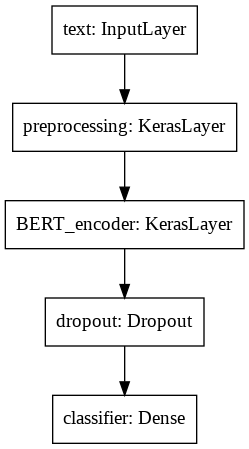

In [10]:
tf.keras.utils.plot_model(model)

In [11]:
#training of the model
#loss function
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()
#optimizer
epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')
#loading BERT model
model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)
print(f'Training model with {bert_model}')
history = model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)

#model evaluation
loss, accuracy = model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/5
625/625 [==============================] - 318s 497ms/step - loss: 0.4833 - binary_accuracy: 0.7506 - val_loss: 0.3901 - val_binary_accuracy: 0.8334
Epoch 2/5
625/625 [==============================] - 303s 484ms/step - loss: 0.3278 - binary_accuracy: 0.8503 - val_loss: 0.3717 - val_binary_accuracy: 0.8462
Epoch 3/5
625/625 [==============================] - 301s 482ms/step - loss: 0.2512 - binary_accuracy: 0.8934 - val_loss: 0.4022 - val_binary_accuracy: 0.8514
Epoch 4/5
625/625 [==============================] - 301s 481ms/step - loss: 0.1948 - binary_accuracy: 0.9240 - val_loss: 0.4239 - val_binary_accuracy: 0.8522
Epoch 5/5
782/782 [==============================] - 166s 212ms/step - loss: 0.4623 - binary_accuracy: 0.8543
Loss: 0.4622524678707123
Accuracy: 0.8542799949645996


In [ ]:
#save the model
dataset_name = 'imdb'
saved_model_path = '/content/drive/MyDrive/297/bert/'

model.save(saved_model_path, include_optimizer=False)

## Testing using saved model

In [50]:
#reloading the saved model fromm drive
reloaded_model = tf.saved_model.load(saved_model_path)

In [ ]:
!pip install gradio

In [49]:
import gradio as gr
def test(name):
  return tf.sigmoid(reloaded_model(tf.constant([name])))[0][0].numpy()

iface = gr.Interface(fn=test, inputs="text", outputs="text")
iface.launch()

Colab notebook detected. To show errors in colab notebook, set `debug=True` in `launch()`
This share link will expire in 72 hours. If you need a permanent link, visit: https://gradio.app/introducing-hosted
Running on External URL: https://33805.gradio.app


(<Flask 'gradio.networking'>,
 'http://127.0.0.1:7869/',
 'https://33805.gradio.app')